In [49]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image
import pandas as pd
import os

MODEL = "microsoft/swinv2-base-patch4-window12-192-22k"
processor = AutoFeatureExtractor.from_pretrained(MODEL, cache_dir="./cache")

val_df = pd.read_json("/projectnb/herbdl/workspaces/faridkar/herbdl/finetuning/datasets/val_astera_50.json", lines=True)
sample = val_df.sample(16)


def preprocess_image(image_path):
    image = Image.open(image_path)
    
    return processor(images=image, return_tensors="pt",).pixel_values.squeeze()

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sample = self.images.iloc[idx]
        file_name = sample['filename']
        image_id = sample['image_id']
        label = sample['label']
        scientific_name = sample['scientific_name']

        return {"pixel_values": preprocess_image(file_name), "image_id": image_id, "label": label, "scientific_name": scientific_name, "filename": file_name}


image_dataset = ImageDataset(sample)
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

/usr3/graduate/faridkar/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/projectnb/herbdl/faridkar/.conda/envs/farid-2024/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [50]:
labels = val_df['label'].unique()
label_map = val_df[['scientific_name', 'label']].drop_duplicates()
label_map = label_map.set_index('label').to_dict()['scientific_name']

label_map

{1: 'Ageratina jucunda',
 12: 'Carphephorus paniculatus',
 16: 'Crepis acuminata',
 9: 'Bidens vulgata',
 4: 'Arnica sororia',
 10: 'Brickellia longifolia',
 39: 'Liatris pilosa',
 5: 'Bidens beckii',
 36: 'Heterotheca pumila',
 22: 'Erigeron melanocephalus',
 44: 'Packera crocata',
 23: 'Erigeron pulcherrimus',
 46: 'Pterocaulon pycnostachyum',
 32: 'Garberia heterophylla',
 27: 'Eurybia divaricata',
 15: 'Chrysopsis subulata',
 20: 'Encelia californica',
 30: 'Eutrochium dubium',
 24: 'Erigeron tener',
 29: 'Eurybia spectabilis',
 3: 'Arnica gracilis',
 17: 'Crepis intermedia',
 2: 'Antennaria marginata',
 43: 'Marshallia graminifolia',
 0: 'Adenophyllum cooperi',
 35: 'Heterotheca polothrix',
 37: 'Hymenoxys hoopesii',
 25: 'Erigeron vagus',
 47: 'Symphyotrichum adnatum',
 11: 'Carphephorus odoratissimus',
 7: 'Bidens eatonii',
 31: 'Gaillardia spathulata',
 38: 'Lepidospartum latisquamum',
 18: 'Crepis occidentalis',
 45: 'Pityopsis falcata',
 19: 'Dieteria canescens',
 42: 'Lygode

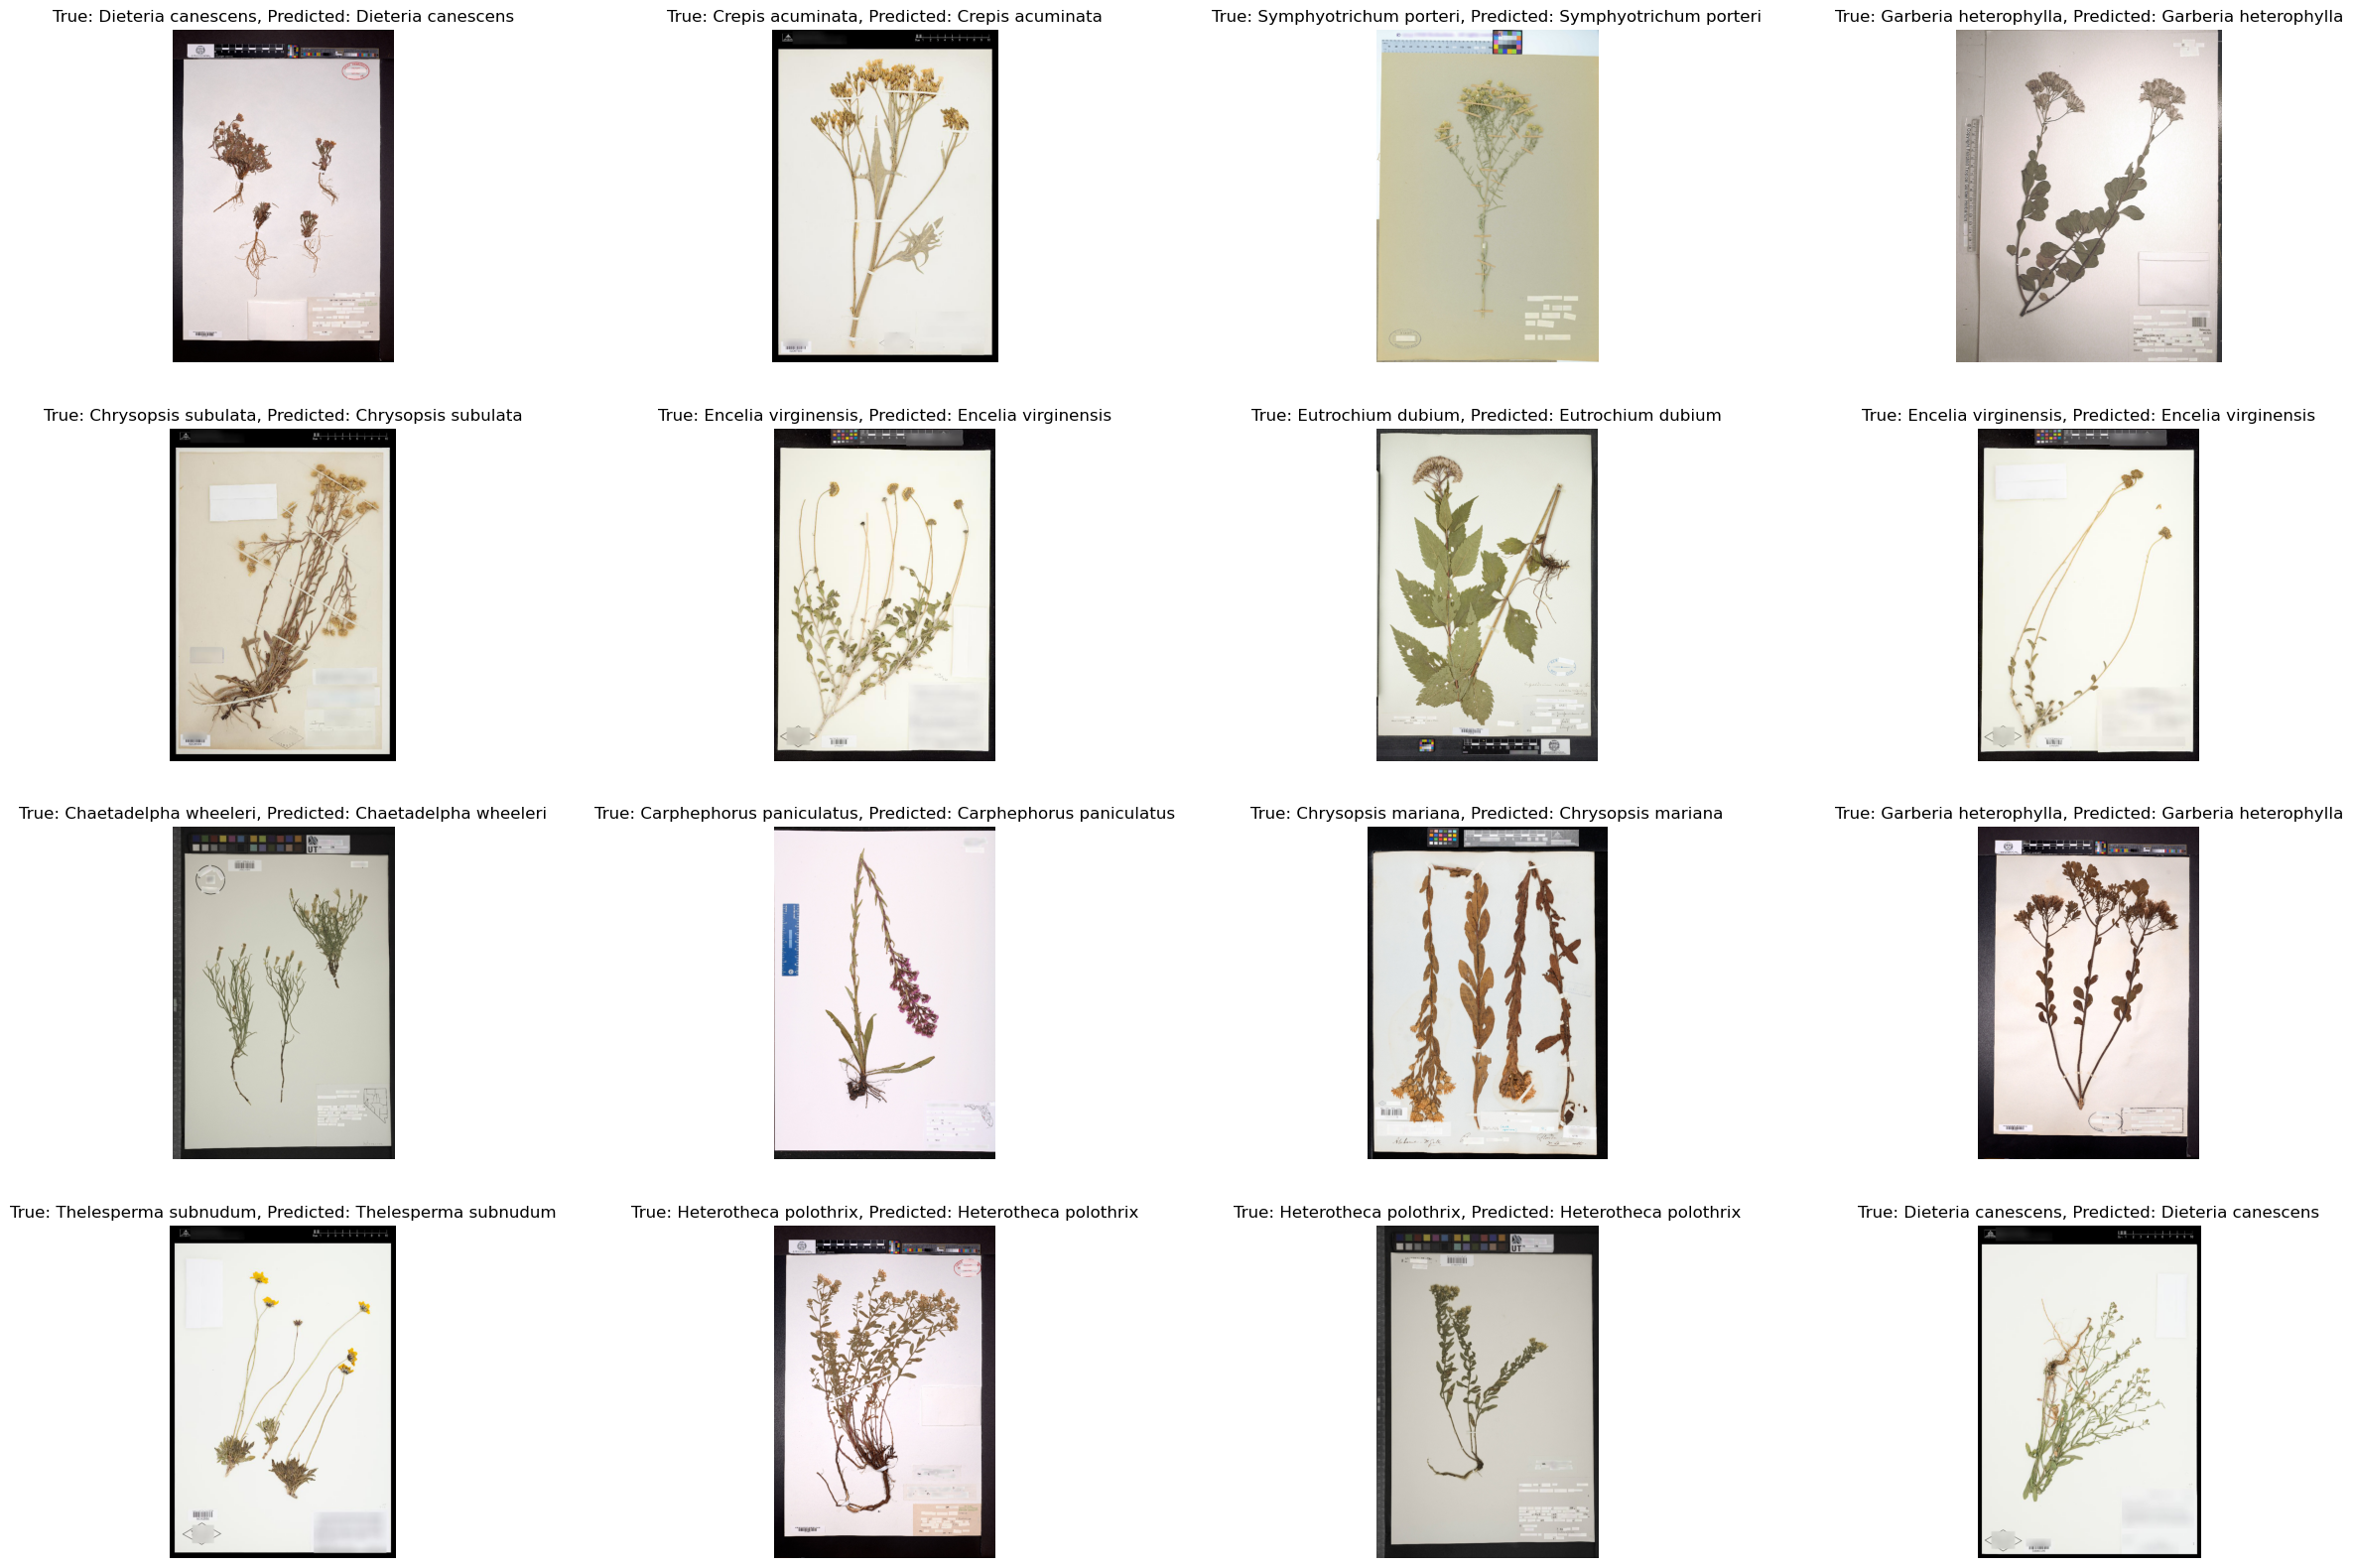

In [53]:
finetuned_path = "/projectnb/herbdl/workspaces/faridkar/herbdl/finetuning/output/SWIN/kaggle22/astera_50"
swin_model = AutoModelForImageClassification.from_pretrained(finetuned_path, cache_dir="./cache")

import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(30, 20))

for i, batch in enumerate(image_loader):
    path = batch['filename'][0]
    image, label = batch['pixel_values'], batch['label']

    output = swin_model(image)
    prediction = output.logits.argmax(dim=1)

    ax[i // 4, i % 4].imshow(Image.open(path))
    ax[i // 4, i % 4].set_title(f"True: {label_map[label.item()]}, Predicted: {label_map[prediction.item()]}")
    ax[i // 4, i % 4].axis('off')

    
plt.show()